<a href="https://colab.research.google.com/github/bdunn20/book_code/blob/main/football_analytics/Ch_8__Principal_Component_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ch. 8 - Principal Component Analysis & Clustering: Player Attributes

PCA is the process of taking a set of features that possess collinearity of some form and "mushing" them into smaller subsets of features that are each (linearly) independent of one another.

Collinearity in this context means the predictors conceptually contain duplicative information and are numerically correlated.

### Packages

In [ ]:
! pip install nfl_data_py

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.3 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13187 sha256=b21db33f85e7f5ee5384ae59eeed7b5c78a8ef2db663bc528cf0523953826c23
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Definitions

*Dimensionality reduction* - taking a set of features that are all-important in their own right, but not completely independent of one another, and creating a smaller set of data column-wise.

*Clustering* - really effective approach in team and individual sports, b/c players are often grouped, either formally or informally, into position groups. Sometimes the nature of these position groups change over time and data can help us detect that change in an effort to help teams adjust their process of building rosters w/ players that fit into their ideas of positions.

### Web Scraping & Visualizing NFL Scouting Combine Data

In [ ]:
combine_py = pd.DataFrame()
for i in range(2000, 2023 + 1):
  url=("https://www.pro-football-reference.com/draft/" + str(i) + "-combine.htm")
  web_data = pd.read_html(url)[0]
  web_data["Season"] = i
  web_data = web_data.query('Ht != "Ht"')
  combine_py = pd.concat([combine_py, web_data])

combine_py.reset_index(drop=True, inplace=True)
combine_py.to_csv("combine_data_py.csv", index=False)

combine_py[["Ht-ft", "Ht-in"]] = combine_py["Ht"].str.split("-", expand=True)

combine_py = combine_py.astype({"Wt": float, "40yd": float, "Vertical": float,
                               "Bench": float, "Broad Jump": float, "3Cone": float,
                               "Shuttle": float, "Ht-ft": float, "Ht-in": float})

combine_py["Ht"] = combine_py["Ht-ft"] * 12.0 + combine_py["Ht-in"]

combine_py.drop(["Ht-ft", "Ht-in"], axis=1, inplace=True)

combine_py.describe()

,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Season
count,7970.000000,7975.000000,7416.000000,6162.000000,5197.000000,6086.000000,4873.000000,4993.000000,7999.000000
mean,73.801255,242.550094,4.773901,32.929698,20.736194,114.776536,7.284773,4.400925,2011.698087
std,2.646040,45.296794,0.305084,4.213438,6.364858,9.376346,0.417058,0.266781,6.950760
min,64.000000,144.000000,4.220000,17.500000,2.000000,74.000000,6.280000,3.730000,2000.000000
25%,72.000000,205.000000,4.530000,30.000000,16.000000,109.000000,6.980000,4.200000,2006.000000
50%,74.000000,232.000000,4.690000,33.000000,21.000000,116.000000,7.190000,4.360000,2012.000000
75%,76.000000,279.500000,4.970000,36.000000,25.000000,121.000000,7.530000,4.560000,2018.000000
max,82.000000,384.000000,6.050000,46.500000,49.000000,147.000000,9.120000,5.560000,2023.000000


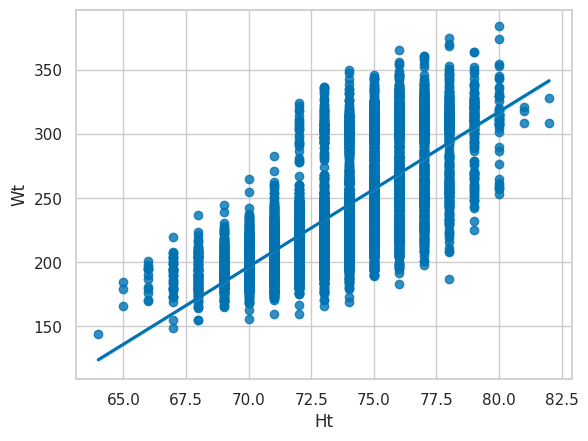

In [ ]:
# pair-wise correlations b/t events
# height vs. weight

sns.set_theme(style="whitegrid", palette="colorblind")
sns.regplot(data=combine_py, x="Ht", y="Wt")
plt.show()

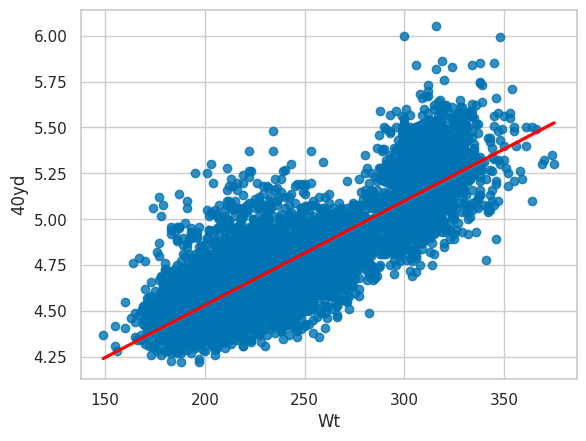

In [ ]:
# weight vs. 40 yd dash time
sns.regplot(data=combine_py, x="Wt", y="40yd", line_kws={"color": "red"})
plt.show()

Note the bi-modal nature: a group centered around 225 lbs and another around 300

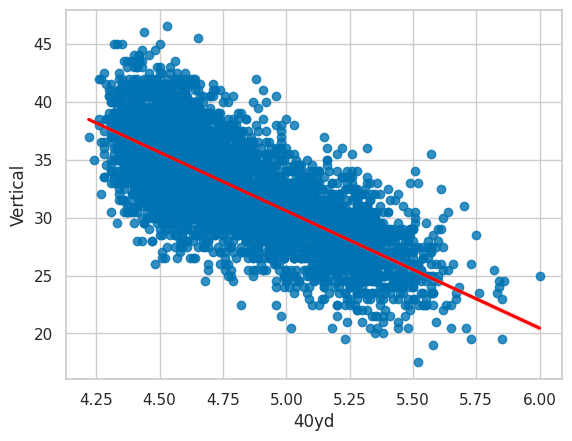

In [ ]:
# 40 yd dash vs vertical jump
sns.regplot(data=combine_py, x="40yd", y="Vertical", line_kws={"color": "red"})
plt.show()

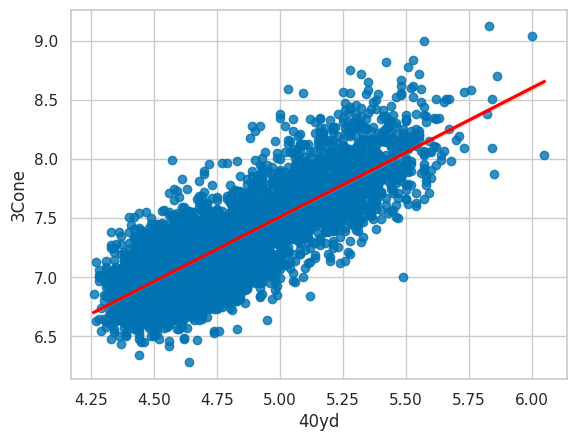

In [ ]:
# 40 yard vs 3 cone drill
sns.regplot(data=combine_py, x="40yd", y="3Cone", line_kws={"color": "red"})
plt.show()

Based on the strong relationships shown in the above graphs, we can infer that while athleticism is measured many different ways, it is reasonable to assume that none of them are independent.

### PCA

In [ ]:
# fill in the missing data using k-nearest neighbors
import numpy as np
import os
from sklearn.impute import KNNImputer

In [ ]:
combine_knn_py_file = "combine_knn_py.csv"
col_impute = ["Ht", "Wt", "40yd", "Vertical", "Bench", "Broad Jump", "3Cone", "Shuttle"]

if not os.path.isfile(combine_knn_py_file):
  combine_knn_py = combine_py.drop(col_impute, axis=1)
  imputer = KNNImputer(n_neighbors=10)
  knn_out_py = imputer.fit_transform(combine_py[col_impute])
  knn_out_py = pd.DataFrame(knn_out_py)
  knn_out_py.columns = col_impute
  combine_knn_py = pd.concat([combine_knn_py, knn_out_py], axis=1)
  combine_knn_py.to_csv(combine_knn_py_file)

else:
  combine_knn_py = pd.read_csv(combine_knn_py_file)

combine_knn_py.describe()

,Season,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle
count,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000
mean,2011.698087,73.801001,242.531054,4.771854,32.968304,20.116413,114.926717,7.239447,4.373734
std,6.950760,2.643153,45.249358,0.300588,3.855688,5.697521,8.766709,0.374693,0.240283
min,2000.000000,64.000000,144.000000,4.220000,17.500000,2.000000,74.000000,6.280000,3.730000
25%,2006.000000,72.000000,205.000000,4.540000,30.500000,16.000000,109.000000,6.978000,4.210000
50%,2012.000000,74.000000,232.000000,4.690000,33.500000,19.800000,116.500000,7.122000,4.310000
75%,2018.000000,76.000000,279.000000,4.970000,35.500000,24.000000,121.000000,7.450000,4.510000
max,2023.000000,82.000000,384.000000,6.050000,46.500000,49.000000,147.000000,9.120000,5.560000


How PCA works:

A PCA reduces the number of dimensions of data to use the fewest possible. Graphically, *dimensions* refer to the number of axes needed to describe the data. Tabularly, *dimensions* refers to the number of independent variables needed to describe the data.

In [ ]:
from sklearn.decomposition import PCA

pca_wt_ht = PCA(svd_solver="full")
wt_ht_py = combine_py[["Wt", "Ht"]].query("Wt.notnull() & Ht.notnull()").copy()
pca_fit_wt_ht_py = pca_wt_ht.fit_transform(wt_ht_py)

In [ ]:
# look at the model details
print(pca_wt_ht.explained_variance_ratio_)

[0.99829949 0.00170051]


So 99.8% of the variability is captured.

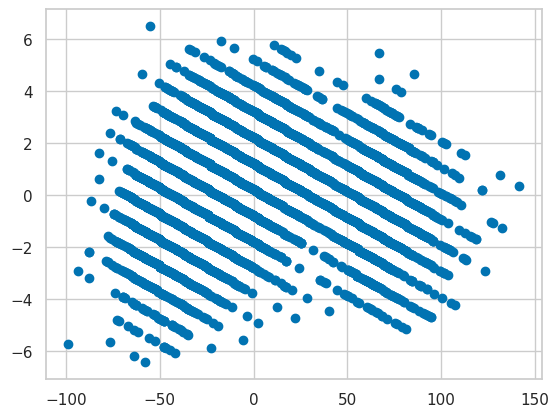

In [ ]:
# plot the data
plt.plot(pca_fit_wt_ht_py[:, 0], pca_fit_wt_ht_py[:, 1], "o")
plt.show()

In [ ]:
# look at the components
pca_wt_ht.components_

array([[ 0.9991454 ,  0.04133366],
       [-0.04133366,  0.9991454 ]])

Interpretation: The first principle component is found by taking the player's weight * 0.999 + height * 0.041.

### PCA on All Data

In [ ]:
# scale data and run PCA
scaled_combine_knn_py = (combine_knn_py[col_impute] -
                         combine_knn_py[col_impute].mean()) / \
                         combine_knn_py[col_impute].std()

pca = PCA(svd_solver="full")
pca_fit_py = pca.fit_transform(scaled_combine_knn_py)

In [ ]:
# view weights of each of the PCs
rotation = pd.DataFrame(pca.components_, index=col_impute)
print(rotation)

                   0         1         2         3         4         5  \
Ht          0.280603  0.393354  0.390361 -0.341077  0.273423 -0.367238   
Wt          0.506579  0.273181 -0.063583  0.448296  0.552755  0.359507   
40yd       -0.709780 -0.001510 -0.082724  0.030549  0.688515 -0.096008   
Vertical   -0.203595  0.032853  0.012344  0.532170 -0.228706  0.296366   
Bench      -0.142295  0.161116  0.593002  0.505059 -0.157804 -0.369933   
Broad Jump  0.206559 -0.081085 -0.613903  0.276086  0.006766 -0.642036   
3Cone      -0.005273 -0.044896  0.028553  0.251729  0.030935 -0.297506   
Shuttle    -0.237609  0.857330 -0.327470 -0.062315 -0.259688  0.035632   

                   6         7  
Ht          0.381355  0.377841  
Wt         -0.109841 -0.129958  
40yd        0.069129 -0.019596  
Vertical    0.523818  0.509498  
Bench      -0.034761 -0.429064  
Broad Jump  0.276778 -0.093787  
3Cone      -0.677537  0.620686  
Shuttle    -0.162692 -0.047240  


In [ ]:
# look at how much of the proportion of variance is explained by each PC
print(pca.explained_variance_)

[5.60551449 0.83106297 0.62445887 0.3753377  0.21709832 0.1391241
 0.12107331 0.08633025]


Note that the first PC handles a significant amount of the variability in the data, but subsequent PCs have some influence as well.

Take the Std deviations, convert them to variances (by squaring them) and then dividing by the sum of all variances to see the percent variance explained by each axis.

In [ ]:
pca_percent_py = pca.explained_variance_ratio_.round(4) * 100
print(pca_percent_py)

[70.07 10.39  7.81  4.69  2.71  1.74  1.51  1.08]


In [ ]:
# access the actual PCs to get something more readily useable
pca_fit_py = pd.DataFrame(pca_fit_py)
pca_fit_py.columns = ["PC" + str(x + 1) for x in range(len(pca_fit_py.columns))]

combine_knn_py = pd.concat([combine_knn_py, pca_fit_py], axis=1)

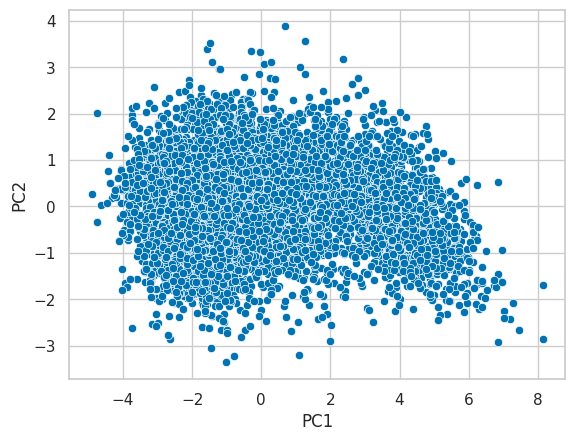

In [ ]:
# graph the first few PCs to see if you have natural clusters
sns.scatterplot(data=combine_knn_py, x="PC1", y="PC2")
plt.show()

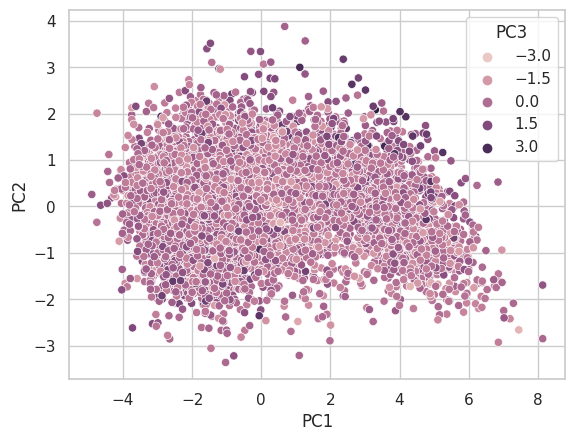

In [ ]:
# two clusters visible above
# shade each point by the value of the third PC
sns.scatterplot(data=combine_knn_py, x="PC1", y="PC2", hue="PC3")
plt.show()

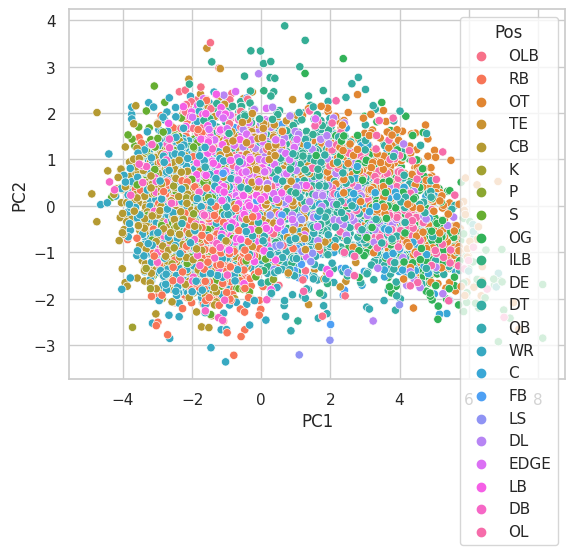

In [ ]:
# interestingly, players on the edges seem to have lower values (darker) for PC3
# shade by position
sns.scatterplot(data=combine_knn_py, x="PC1", y="PC2", hue="Pos")
plt.show()

### Clustering Combine Data

In [ ]:
# use kmeans and fit for 6 centers (set seed to 1234)

from scipy.cluster.vq import vq, kmeans

k_means_fit_py = kmeans(combine_knn_py[["PC1", "PC2"]], 6, seed=1234)

In [ ]:
# attach clusters to dataset
combine_knn_py["cluster"] = vq(combine_knn_py[["PC1", "PC2"]], k_means_fit_py[0])[0]

combine_knn_py.head()

,Player,Pos,School,College,Drafted (tm/rnd/yr),Season,Ht,Wt,40yd,Vertical,...,Shuttle,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,cluster
0,John Abraham,OLB,South Carolina,NaN,New York Jets / 1st / 13th pick / 2000,2000,76.0,252.0,4.55,33.80,...,4.224,-0.565969,0.980773,-0.474795,-0.550815,-0.295916,0.345214,-0.147108,0.292072,3
1,Shaun Alexander,RB,Alabama,College Stats,Seattle Seahawks / 1st / 19th pick / 2000,2000,72.0,218.0,4.58,34.35,...,4.250,-1.431579,-0.063408,0.331781,0.007999,-0.141523,-0.080752,-0.073004,0.060097,1
2,Darnell Alford,OT,Boston Col.,NaN,Kansas City Chiefs / 6th / 188th pick / 2000,2000,76.0,334.0,5.56,25.00,...,4.980,5.987965,-1.389487,-0.116521,1.026213,0.323902,0.043452,-0.491836,-0.068816,0
3,Kyle Allamon,TE,Texas Tech,NaN,NaN,2000,74.0,253.0,4.97,29.00,...,4.490,1.411708,-0.929340,-0.022235,-0.598828,0.146888,0.100129,0.328596,-0.059738,2
4,Rashard Anderson,CB,Jackson State,NaN,Carolina Panthers / 1st / 23rd pick / 2000,2000,74.0,206.0,4.55,34.00,...,4.150,-1.537493,0.229250,-0.344051,-0.100172,-0.314806,0.057401,-0.674860,-0.276822,1


In [ ]:
# do clusters bring like players and/or position types together?
print(combine_knn_py.query("cluster == 1").groupby("Pos")\
      .agg({"Ht": ["count", "mean"], "Wt": ["count", "mean"]}))

        Ht               Wt            
     count       mean count        mean
Pos                                    
CB     219  72.442922   219  197.525114
DB      27  72.074074    27  201.074074
DE      13  75.384615    13  250.307692
EDGE     4  74.250000     4  247.000000
FB       8  72.500000     8  235.000000
ILB     19  73.736842    19  237.789474
K        7  73.571429     7  202.714286
LB      42  73.650000    42  234.688095
OLB     76  73.960526    76  236.631579
P       21  74.285714    21  205.904762
QB      39  74.384615    39  216.692308
RB     161  71.222360   161  216.900621
S      217  72.820276   217  209.304147
TE      18  75.555556    18  244.611111
WR     403  73.765509   403  207.673697


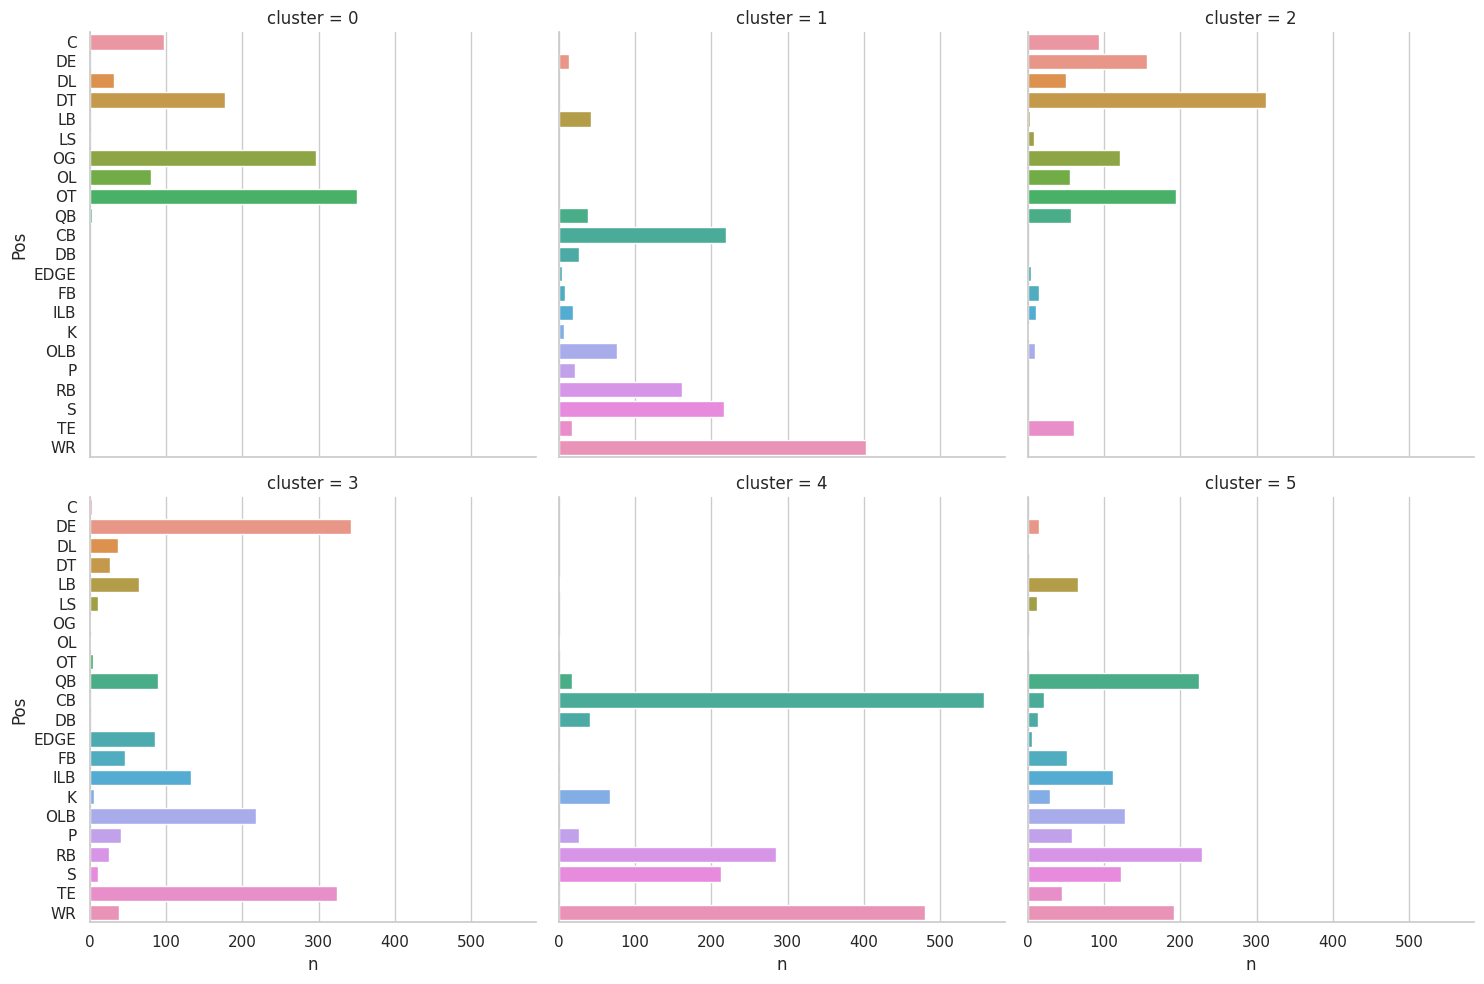

In [ ]:
# plot summary for all clusters
combine_knn_py_cluster = combine_knn_py.groupby(["cluster", "Pos"])\
          .agg({"Ht": ["count", "mean"], "Wt": ["mean"]})

combine_knn_py_cluster.columns = list(map("_".join, combine_knn_py_cluster.columns))

combine_knn_py_cluster.reset_index(inplace=True)

combine_knn_py_cluster.rename(columns={"Ht_count": "n", "Ht_mean": "Ht",
                                       "Wt_mean": "Wt"}, inplace=True)

combine_knn_py_cluster.cluster = combine_knn_py_cluster.cluster.astype(str)

sns.catplot(combine_knn_py_cluster, x="n", y="Pos", col="cluster", col_wrap=3, kind="bar")
plt.show()

Cluster 0 seems to be larger players (OL, IDL)

Cluster 1 mostly CB/S/WR w/ some RB

Cluster 2 similar to 0, but add DE & TE

Cluster 3 heavily DE/TE & OLB

Cluster 4 very similar to 1

Cluster 5 lots of QB and other skill positions

In [ ]:
# summarize cluster to compare height & weight
combine_knn_py_cluster.groupby("cluster").agg({"Ht": ["mean"], "Wt": ["mean"]})

,Ht,Wt
,mean,mean
cluster,,
0,75.860474,293.449770
1,73.573629,222.921131
2,74.981939,272.142925
3,75.132763,250.473022
4,71.006182,204.327454
5,73.169902,228.650865


As we hypothesized above, clusters 1 & 4 contain largely the same positions, but cluster 1 includes much larger players in terms of Ht/Wt. Clusters 0 & 2 show similar.